# Engineering proximity spatial features

In [21]:
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
listings = pd.read_csv('../data/listings.csv.gz')

In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37548 entries, 0 to 37547
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            37548 non-null  int64  
 1   listing_url                                   37548 non-null  object 
 2   scrape_id                                     37548 non-null  int64  
 3   last_scraped                                  37548 non-null  object 
 4   source                                        37548 non-null  object 
 5   name                                          37546 non-null  object 
 6   description                                   36504 non-null  object 
 7   neighborhood_overview                         20574 non-null  object 
 8   picture_url                                   37547 non-null  object 
 9   host_id                                       37548 non-null 

In [5]:
listings_gdf = gpd.GeoDataFrame(listings, 
                               geometry=gpd.points_from_xy(
                                   listings.longitude, 
                                   listings.latitude
                               ), crs=4326)

In [6]:
boroughs = gpd.read_file('../data/NYC Boroughs/nybb_22a/nybb.shp')

In [7]:
manhattan = boroughs[boroughs.BoroName == 'Manhattan']
manhattan = manhattan.to_crs(4326)

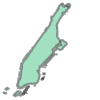

In [9]:
manhattan.loc[3, 'geometry']

In [10]:
manhattan_mask = listings_gdf.within(manhattan.loc[3, 'geometry'])

In [12]:
listings_manhattan = listings_gdf.loc[manhattan_mask]
listings_manhattan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 16463 entries, 0 to 37540
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            16463 non-null  int64   
 1   listing_url                                   16463 non-null  object  
 2   scrape_id                                     16463 non-null  int64   
 3   last_scraped                                  16463 non-null  object  
 4   source                                        16463 non-null  object  
 5   name                                          16462 non-null  object  
 6   description                                   16082 non-null  object  
 7   neighborhood_overview                         9088 non-null   object  
 8   picture_url                                   16463 non-null  object  
 9   host_id                                       1

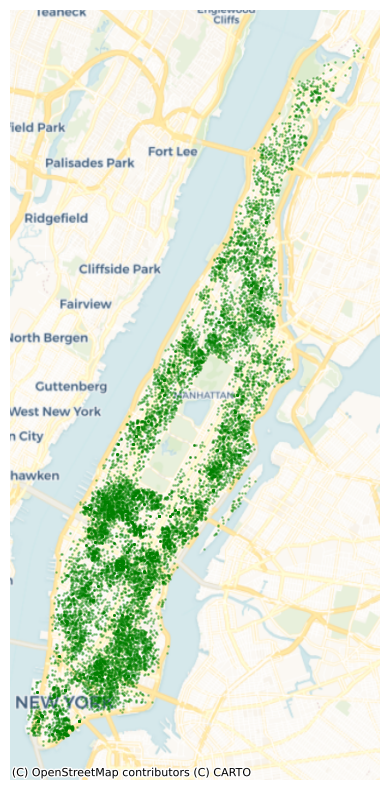

In [15]:
f, ax = plt.subplots(figsize=(10,10))
listings_manhattan.plot(ax=ax, color='g', alpha=0.3, markersize=1)
ctx.add_basemap(ax, crs=listings_manhattan.crs, 
               source=ctx.providers.CartoDB.Voyager)
ax.set_axis_off();

>Proximity to attractions

In [17]:
nyc_attr = pd.read_csv('../data/NYC_Attractions/NYC Attractions.csv')

In [18]:
nyc_attr_gdf = gpd.GeoDataFrame(
    nyc_attr, 
    geometry=gpd.points_from_xy(nyc_attr.Longitude, nyc_attr.Latitude), 
    crs=4326
)
print(nyc_attr_gdf.head(9))

              Attraction  Latitude  Longitude                  geometry
0           Central Park   40.7851   -73.9683  POINT (-73.9683 40.7851)
1       Central Park Zoo   40.7678   -73.9718  POINT (-73.9718 40.7678)
2  Empire State Building   40.7484   -73.9857  POINT (-73.9857 40.7484)
3      Statue of Liberty   40.6892   -74.0445  POINT (-74.0445 40.6892)
4    Rockeffeller Center   40.7587   -73.9787  POINT (-73.9787 40.7587)
5      Chrysler Building   40.7516   -73.9755  POINT (-73.9755 40.7516)
6           Times Square   40.7580   -73.9855   POINT (-73.9855 40.758)
7                   MoMa   40.7614   -73.9776  POINT (-73.9776 40.7614)
8          Charging Bull   40.7046   -74.0139  POINT (-74.0139 40.7046)


In [22]:
from matplotlib.lines import Line2D

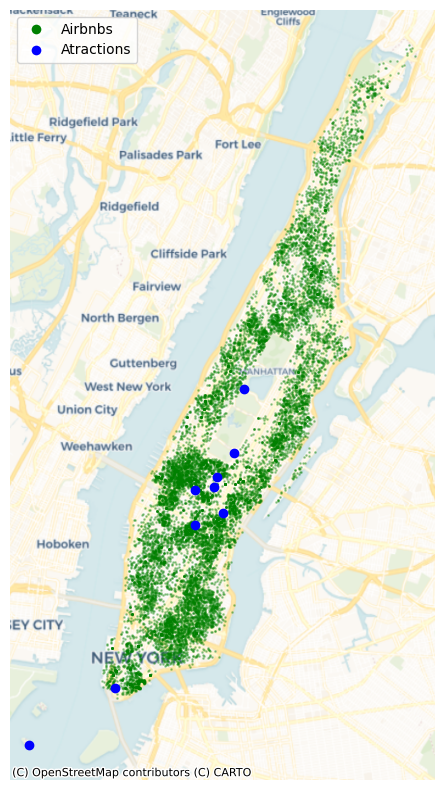

In [24]:
f, ax = plt.subplots(figsize=(10,10))
listings_manhattan.plot(ax=ax, color='g', alpha=0.3, markersize=1)
nyc_attr_gdf.plot(ax=ax, color='b')
ctx.add_basemap(ax, crs=nyc_attr_gdf.crs, source=ctx.providers.CartoDB.Voyager)
ax.set_axis_off()
green_circle = Line2D([0], [0], marker='o', color='w', 
                     label='Airbnbs', markerfacecolor='g', markersize=8)
blue_circle = Line2D([0], [0], marker='o', color='w', 
                     label='Atractions', markerfacecolor='b', markersize=8)
plt.legend(handles=[green_circle, blue_circle]);

>Calculate distance between listings and attractions

In [25]:
attractions = nyc_attr_gdf.Attraction.unique()

In [26]:
nyc_attr_gdf_p = nyc_attr_gdf.to_crs(2263)
listings_manhattan_p = listings_manhattan.to_crs(2263)

In [30]:
distances = listings_manhattan_p.geometry.apply(
    lambda g: nyc_attr_gdf_p.distance(g)
)

In [31]:
distances.columns = attractions

In [32]:
distances.head()

,Central Park,Central Park Zoo,Empire State Building,Statue of Liberty,Rockeffeller Center,Chrysler Building,Times Square,MoMa,Charging Bull
0,12449.142142,6442.861743,1880.201525,28573.983993,2674.064858,2885.318939,1617.828542,3613.682362,19487.118912
2,9202.777723,14578.797153,22606.799884,49590.742578,18399.171063,20202.287705,19690.746182,17410.221018,40325.026086
3,5817.566046,9896.884833,17812.529280,44846.156751,13656.433633,15281.346020,15098.805481,12706.733421,35440.035811
8,8254.850346,4115.740150,6868.965009,32643.167435,3810.349316,6480.233270,3381.216049,3286.053256,24039.616708
11,23044.855588,16673.262428,9283.069743,20838.277146,13098.586551,10686.760389,12774.568895,14110.917254,10688.072134


In [33]:
distances.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16463 entries, 0 to 37540
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Central Park           16463 non-null  float64
 1   Central Park Zoo       16463 non-null  float64
 2   Empire State Building  16463 non-null  float64
 3   Statue of Liberty      16463 non-null  float64
 4   Rockeffeller Center    16463 non-null  float64
 5   Chrysler Building      16463 non-null  float64
 6   Times Square           16463 non-null  float64
 7   MoMa                   16463 non-null  float64
 8   Charging Bull          16463 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB


In [35]:
listings_manhattan_p.crs.axis_info[0].unit_name

'US survey foot'

In [38]:
# to miles 
distances = distances.apply(lambda x: x/5280, axis=1)

In [39]:
print(distances.head(5))

    Central Park  Central Park Zoo  Empire State Building  Statue of Liberty  \
0       2.357792          1.220239               0.356099           5.411739   
2       1.742950          2.761136               4.281591           9.392186   
3       1.101812          1.874410               3.373585           8.493590   
8       1.563419          0.779496               1.300940           6.182418   
11      4.364556          3.157815               1.758157           3.946643   

    Rockeffeller Center  Chrysler Building  Times Square      MoMa  \
0              0.506452           0.546462      0.306407  0.684410   
2              3.484691           3.826191      3.729308  3.297390   
3              2.586446           2.894194      2.859622  2.406578   
8              0.721657           1.227317      0.640382  0.622359   
11             2.480793           2.024008      2.419426  2.672522   

    Charging Bull  
0        3.690742  
2        7.637316  
3        6.712128  
8        4.552958 

In [42]:
# Check to see which locations are less than 2 miles
distances_1mi = distances.apply(lambda x: x <=1, axis=1).sum(axis=1)
distances_2mi = distances.apply(lambda x: x <=2, axis=1).sum(axis=1)
distances_3mi = distances.apply(lambda x: x <=3, axis=1).sum(axis=1)
distances_4mi = distances.apply(lambda x: x <=4, axis=1).sum(axis=1)
distances_5mi = distances.apply(lambda x: x <=5, axis=1).sum(axis=1)
distances_6mi = distances.apply(lambda x: x <=6, axis=1).sum(axis=1)
# Creating a dataframe combining all the distance bands
distance_df = pd.concat([distances_1mi,distances_2mi,
                         distances_3mi,distances_4mi,
                         distances_5mi,distances_6mi],
                        axis=1)
distance_df.columns = ['Attr_1mi','Attr_2mi','Attr_3mi',
                       'Attr_4mi','Attr_5mi','Attr_6mi']
distance_df.head()

,Attr_1mi,Attr_2mi,Attr_3mi,Attr_4mi,Attr_5mi,Attr_6mi
0,5,6,7,8,8,9
2,0,1,2,6,7,7
3,0,2,6,7,7,7
8,4,7,7,7,8,8
11,0,1,6,8,9,9


>Merge the summary bands to original set

In [43]:
listings_manhattan = listings_manhattan.merge(
    distances, left_index=True, right_index=True)
listings_manhattan = listings_manhattan.merge(
    distance_df, left_index=True, right_index=True)

In [45]:
listings_manhattan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 16463 entries, 0 to 37540
Data columns (total 91 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            16463 non-null  int64   
 1   listing_url                                   16463 non-null  object  
 2   scrape_id                                     16463 non-null  int64   
 3   last_scraped                                  16463 non-null  object  
 4   source                                        16463 non-null  object  
 5   name                                          16462 non-null  object  
 6   description                                   16082 non-null  object  
 7   neighborhood_overview                         9088 non-null   object  
 8   picture_url                                   16463 non-null  object  
 9   host_id                                       1